In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def intercos(y, keys=None, center=False, sample_size=-1):
    if center: y = StandardScaler(with_std=False).fit(y).transform(y) 
    if sample_size >= 0:
        assert(keys is not None)
        assert(sample_size == int(sample_size))
        all_y = []
        for k in np.unique(keys):
            y_k = y[keys==k]
            if y_k.shape[0] < 1: continue
            all_y.append(y_k)
        y = np.vstack(all_y)
    cos = cosine_similarity(y, y)
    avg_cos = ( np.sum(np.sum(cos)) - cos.shape[0] ) / 2 / ( cos.shape[0]*(cos.shape[0]-1) / 2 )
    return avg_cos

def intracos(y, keys, center=False):
    if center: y = StandardScaler(with_std=False).fit(y).transform(y) 
    all_cos = []
    for k in np.unique(keys):
        tmp = y[keys==k]
        if tmp.shape[0] <= 1:
            continue
        if tmp.shape[0] >= 1000: # maximum 1000 points to estimate
            idx = np.random.choice(len(tmp), 1000, replace=False)
            tmp = tmp[idx]
        avg_cos = intercos(tmp)
        all_cos.append(avg_cos)
    avg_cos = np.mean(all_cos)
    return avg_cos

def iso_paper_cosine(y, labels, keys):
    arg_center = True
    all_inter = []
    all_intra = []
    for i in np.unique(labels):
        y_tmp = y[labels==i]
        keys_tmp = keys[labels==i]
        cos = intercos(y_tmp, keys=keys_tmp, center=arg_center, sample_size=1)
        if not np.isnan(cos) and not np.isinf(cos):
            all_inter.append(cos)
        cos = intracos(y_tmp, keys_tmp, center=arg_center)
        if not np.isnan(cos) and not np.isinf(cos):
            all_intra.append(cos)
    print('clustered inter cos:', np.mean(all_inter))
    print('clustered intra cos:', np.mean(all_intra))
    a = np.mean(all_inter)
    b = np.mean(all_intra)
    return a, b

In [3]:
def get_data_name_dire(path, layer, dire, dd, speed, noise=None, mosaic=None):
    nm = f"{path}/dire{dire}_{dd}_full_gpt2_layer{layer}_speed{speed}"
    if noise is not None:
        nm += f"_noise{noise}"
    if mosaic is not None:
        nm += f"_mosaic{mosaic}"
    return nm

In [4]:
def run_cos_exp(exps, eq='eq3', both_figures=True):
    cluster_save_path = 'result_cluster'
    tdd_inter_dict = {}
    tdd_intra_dict = {}

    for exp in exps:
        tdd_inter_cosine_values = []
        tdd_intra_cosine_values = []
        for i in range(6):  
            dire, dd, speed, noise = exp

            data_name = get_data_name_dire(cluster_save_path, i, dire, dd, speed, noise)
            key = f"{speed} km/hour"
            tdd_labels = np.load(f"{data_name}_cluster.npy")
            tdd_y_l = np.load(f"{data_name}.npy")
            tdd_y_index_iekey = np.load(f"{data_name}_index.npy")
            
            if eq == 'eq1':
                # tdd_labels replaced with all 0 for eq1
                tdd_labels = np.zeros_like(tdd_labels)

            inter_cos, intra_cos = iso_paper_cosine(tdd_y_l, tdd_labels, tdd_y_index_iekey)
            tdd_inter_cosine_values.append(inter_cos)
            tdd_intra_cosine_values.append(intra_cos)

        tdd_inter_dict[key] = tdd_inter_cosine_values
        tdd_intra_dict[key] = tdd_intra_cosine_values

    if both_figures:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        tdd_inter_df = pd.DataFrame(tdd_inter_dict)
        tdd_intra_df = pd.DataFrame(tdd_intra_dict)
        
        tdd_inter_df.plot(ax=ax[0], linewidth=3, marker='o')
        tdd_inter_df.plot(ax=ax[1], linewidth=3, marker='o')

        ax[0].set_title(f'Zoom-Out', fontsize=24)
        ax[1].set_title(f'Zoom-In', fontsize=24)
        ax[0].set_ylim(-1, 1)

        ax[0].legend(fontsize=16, loc='upper left')
        ax[1].legend(fontsize=16, loc='upper left')
        
        ax[0].set_xlabel('Layer ID', fontsize=24)
        ax[0].set_ylabel('Cosine', fontsize=24)
        ax[1].set_xlabel('Layer ID', fontsize=24)
        ax[1].set_ylabel('Cosine', fontsize=24)
        ax[0].grid(True)
        ax[1].grid(True)

        ax[0].tick_params(axis='both', which='major', labelsize=18)
        ax[1].tick_params(axis='both', which='major', labelsize=18)
        
        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

        tdd_inter_df = pd.DataFrame(tdd_inter_dict)
        tdd_inter_df.plot(ax=ax, linewidth=3, marker='o')
       
        ax.legend(fontsize=16, loc='upper left')
        ax.set_xlabel('Layer ID', fontsize=24)
        ax.set_ylabel('Cosine', fontsize=24)
        ax.tick_params(axis='both', which='major', labelsize=18)

        plt.grid(True)
        plt.tight_layout()
        plt.show()

clustered inter cos: 0.015546921898449225
clustered intra cos: 0.25525163426116415
clustered inter cos: 0.018022622262312434
clustered intra cos: 0.2741314851491157
clustered inter cos: 0.01853341797766432
clustered intra cos: 0.41053740685532925
clustered inter cos: 0.004366097993078697
clustered intra cos: 0.44344361800401244
clustered inter cos: 0.009159726089262901
clustered intra cos: 0.3964781539594701
clustered inter cos: 0.008118719713582887
clustered intra cos: 0.39859251908828713
clustered inter cos: 0.005687184516819609
clustered intra cos: 0.11634248201271796
clustered inter cos: 0.004392949452839127
clustered intra cos: 0.11265883724996816
clustered inter cos: 0.015444641039505751
clustered intra cos: 0.2611796491083969
clustered inter cos: 0.01193492313141647
clustered intra cos: 0.17882834637561337
clustered inter cos: 0.019101131473828796
clustered intra cos: 0.1720207018796203
clustered inter cos: 0.015668264279731007
clustered intra cos: 0.14011972241684523
clustered 

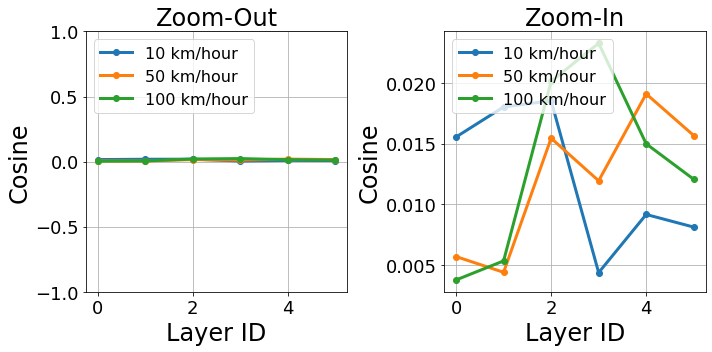

In [5]:
exps = [
        [16, 'tdd', 10, 18],
        [16, 'tdd', 50, 18],
        [16, 'tdd', 100, 18],
        ]

run_cos_exp(exps, eq='eq3')

clustered inter cos: 0.001368235631487619
clustered intra cos: 0.19020741183464301
clustered inter cos: 0.001228141048063094
clustered intra cos: 0.19501824954228478
clustered inter cos: 0.07498044334667334
clustered intra cos: 0.24237986522837057
clustered inter cos: 0.07377332416208104
clustered intra cos: 0.2297578550794288
clustered inter cos: 0.20863680277638819
clustered intra cos: 0.3226935160300666
clustered inter cos: 0.16747572223611806
clustered intra cos: 0.2798605554918666
clustered inter cos: 0.0011166054218515508
clustered intra cos: 0.07708513231937075
clustered inter cos: 0.000822035040957979
clustered intra cos: 0.073592563611193
clustered inter cos: 0.09740677369934968
clustered intra cos: 0.16763949268037737
clustered inter cos: 0.05711354114557279
clustered intra cos: 0.13022577013942477
clustered inter cos: 0.17514546335667833
clustered intra cos: 0.23115240689617336
clustered inter cos: 0.1527910048774387
clustered intra cos: 0.20794044650173926
clustered inter c

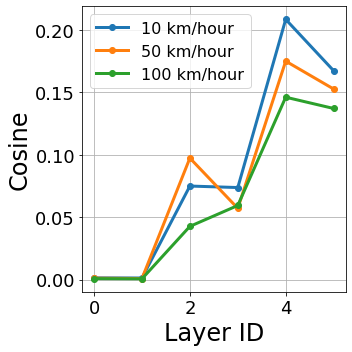

In [6]:
exps = [
        [16, 'fdd', 10, 5],
        [16, 'fdd', 50, 5],
        [16, 'fdd', 100, 5],
        ]

run_cos_exp(exps, eq='eq1', both_figures=False)